In [1]:
import fair
import numpy as np
import os
import matplotlib.pyplot as plt
fair.__version__

/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.1.0'

In [2]:
f = fair.FAIR()
f

# New Workflow in V2 (not fair_scm!)

From documentation: 
https://docs.fairmodel.net/en/latest/examples/basic_run_example.html

Create the FAIR instance, inititalised with run control options.

Define the time horizon of the problem with FAIR.define_time()

Define the scenarios to be run (e.g. SSPs, IAM emissions scenarios, or anything you want) with FAIR.define_scenarios().

Define the configurations to be run with FAIR.define_configs(). A configuration (config) is a set of parameters that describe climate response and species response parameters. For example you might have a config with high climate sensitivity and strong aerosol forcing, and one with low climate sensitivity and weak aerosol forcing.

Define which species will be included in the problem, and their properties including the run mode (e.g. emissions-driven, concentration driven) with FAIR.define_species().

Optionally, modify run control options.

Create input and output DataArrays with FAIR.allocate().

Fill in the DataArrays (e.g. emissions), climate configs, and species configs, by either working directly with the xarray API, or using FaIR-packaged convenience functions like fill and initialise.

Run: FAIR.run().

Analyse results by accessing the DataArrays that are attributes of FAIR.



## Scenarios and Configs

contains all information about the scenario(s), the forcer(s) we want to investigate, and any configurations specific to each species and the response of the climate.

Multiple scenarios and configs can be supplied in a FAIR instance, and due to internal parallelisation is the fastest way to run the model (100 ensemble members per second for 1750-2100 on my Mac for an emissions driven run). The total number of scenarios that will be run is the product of scenarios and configs. For example we might want to run three emissions scenarios – let’s say SSP1-2.6, SSP2-4.5 and SSP3-7.0 – using climate calibrations (configs) from the UKESM, GFDL, MIROC and NorESM climate models. This would give us a total of 12 ensemble members in total which are run in parallel.

In [3]:
"""
f.define_time(2000, 2050, 1)
f.define_scenarios(['abrupt', 'ramp'])
f.define_configs(['high', 'central', 'low'])
f.define_species(species, properties)
f.ghg_method='Myhre1998'
"""

"\nf.define_time(2000, 2050, 1)\nf.define_scenarios(['abrupt', 'ramp'])\nf.define_configs(['high', 'central', 'low'])\nf.define_species(species, properties)\nf.ghg_method='Myhre1998'\n"

In [4]:
# define timebounds(start, end, interval=1 year)
f.define_time(1750, 2100, 1)
print("Last few Time Points: ", f.timepoints[-30:]) #numpy arrays
print("\n Time bounds: ", f.timebounds[-30:])

Last few Time Points:  [2070.5 2071.5 2072.5 2073.5 2074.5 2075.5 2076.5 2077.5 2078.5 2079.5
 2080.5 2081.5 2082.5 2083.5 2084.5 2085.5 2086.5 2087.5 2088.5 2089.5
 2090.5 2091.5 2092.5 2093.5 2094.5 2095.5 2096.5 2097.5 2098.5 2099.5]

 Time bounds:  [2071. 2072. 2073. 2074. 2075. 2076. 2077. 2078. 2079. 2080. 2081. 2082.
 2083. 2084. 2085. 2086. 2087. 2088. 2089. 2090. 2091. 2092. 2093. 2094.
 2095. 2096. 2097. 2098. 2099. 2100.]


In [5]:
# define scenarios, which are really just labels to help create track during parallelization
f.define_scenarios(["Emissions", "SAI"])
f.scenarios

['Emissions', 'SAI']

In [6]:
# Define three configs, also a labelling tool. Different climate parameters
f.define_configs(["high", "central", "low"]) # input: list of names to run
f.configs

['high', 'central', 'low']

In [7]:
# Species: which forcers and important factors are at play
# Species could be a chemical such as CO2 or category like forcing from prevursor emissions
# species name to identify as well as properties dictionary for behavior
# so can run multigas but selectively filter which of the 40 species care about

species = ['CO2 fossil emissions', 'CO2 AFOLU emissions', 'Sulfur', 'CH4', 'N2O', 'CO2', 'ERFari', 'ERFaci']

properties = { # can get hella big
    'CO2 fossil emissions': {
        'type': 'co2 ffi',
        'input_mode': 'emissions',
        'greenhouse_gas': False,  # it doesn't behave as a GHG itself in the model, but as a precursor
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CO2 AFOLU emissions': {
        'type': 'co2 afolu',
        'input_mode': 'emissions',
        'greenhouse_gas': False,  # it doesn't behave as a GHG itself in the model, but as a precursor
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CO2': {
        'type': 'co2',
        'input_mode': 'calculated',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'CH4': {
        'type': 'ch4',
        'input_mode': 'concentration',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': True, # we treat methane as a reactive gas
    },
    'N2O': {
        'type': 'n2o',
        'input_mode': 'concentration',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': True, # we treat nitrous oxide as a reactive gas
    },
    'Sulfur': {
        'type': 'sulfur',
        'input_mode': 'emissions',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': True,
        'aerosol_chemistry_from_concentration': False,
    },
    'ERFari': {
        'type': 'ari',
        'input_mode': 'calculated',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
    'ERFaci': {
        'type': 'aci',
        'input_mode': 'calculated',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    }
}

f.define_species(species, properties) # can access .species, .properties

In [8]:
help(f)

Help on FAIR in module fair.fair object:

class FAIR(builtins.object)
 |  FAIR(n_gasboxes=4, n_layers=3, iirf_max=100, br_cl_ods_potential=45, ghg_method='meinshausen2020', ch4_method='leach2021', temperature_prescribed=False)
 |  
 |  Initialise FaIR.
 |  
 |  Parameters
 |  ----------
 |  n_gasboxes : int
 |      the number of atmospheric greenhouse gas boxes to run the model with
 |  n_layers : int
 |      the number of ocean layers in the energy balance or impulse
 |      response model to run with
 |  iirf_max : float
 |      limit for time-integral of greenhouse gas impulse response function.
 |  br_cl_ods_potential : float
 |      factor describing the ratio of efficiency that each bromine atom
 |      has as an ozone depleting substance relative to each chlorine atom.
 |  ghg_method : str
 |      method to use for calculating greenhouse gas forcing from CO\ :sub:`2`,
 |      CH\ :sub:`4` and N\ :sub:`2`O. Valid options are {"leach2021",
 |      "meinshausen2020", "etminan2016",

In [9]:
print(f.ghg_method)
print(f.iirf_max)
print()

meinshausen2020
100



## Populating the model with data

In our RL setup, this is what our model will optimize

In [10]:
# with parameters set up, actually create data to input
f.allocate() # sets up instance variables based on all configs. DO THIS AFTER PREVIOUS STEPS
f.emissions # (350 x 2 x 3 x 8) ~ (num_years x n_scenarios x n_configs x specie)


<xarray.DataArray (timepoints: 350, scenario: 2, config: 3, specie: 8)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.098e+03 2.1e+03
  * scenario    (scenario) <U9 'Emissions' 'SAI'
  * config      (config) <U7 'high' 'central' 'low'
  * specie      (specie) <U20 'CO2 fossil emissions' ... 'ERFaci'

In [11]:
((dict(specie=species[2], scenario="Emissions")))

{'specie': 'Sulfur', 'scenario': 'Emissions'}

In [12]:
f.emissions.loc[(dict(specie=species[2], scenario="Emissions"))] = 24
f.emissions.sel(scenario='Emissions', specie=species[3], config='high')[:15]

<xarray.DataArray (timepoints: 15)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 1.764e+03 1.764e+03
    scenario    <U9 'Emissions'
    config      <U7 'high'
    specie      <U20 'CH4'

In [13]:
f.scenarios

['Emissions', 'SAI']

In [14]:
f.timebounds.size

351

In [15]:
fair.interface.fill(f.emissions, 38, scenario='Emissions', specie='CO2 fossil emissions')
fair.interface.fill(f.emissions, 3, scenario='Emissions', specie='CO2 AFOLU emissions')
fair.interface.fill(f.emissions, 100, scenario='Emissions', specie='Sulfur')
fair.interface.fill(f.concentration, 1800, scenario='Emissions', specie='CH4')
fair.interface.fill(f.concentration, 325, scenario='Emissions', specie='N2O')

for config in f.configs:
    fair.interface.fill(f.emissions, np.linspace(0, 38, f.timepoints.size), scenario='SAI', config=config, specie='CO2 fossil emissions')
    fair.interface.fill(f.emissions, np.linspace(0, 3, f.timepoints.size), scenario='SAI', config=config, specie='CO2 AFOLU emissions')
    fair.interface.fill(f.emissions, np.linspace(2.2, 100, f.timepoints.size), scenario='SAI', config=config, specie='Sulfur')
    fair.interface.fill(f.concentration, np.linspace(729, 1800, f.timebounds.size), scenario='SAI', config=config, specie='CH4')
    fair.interface.fill(f.concentration, np.linspace(270, 325, f.timebounds.size), scenario='SAI', config=config, specie='N2O')

In [16]:
f.emissions

<xarray.DataArray (timepoints: 350, scenario: 2, config: 3, specie: 8)>
array([[[[3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan]],

        [[0.00000000e+00, 0.00000000e+00, 2.20000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 2.20000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 2.20000000e+00, ...,
                     nan,            nan,            nan]]],


       [[[3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
...
                     nan,            nan,            nan],
         [3.78911175e+01, 2.99140401e+00, 9.97197708e+01, ...,
                     nan,            nan,            nan],
         [3.78911175e+01, 2.99140401e+00, 9.97197708e+01, ...,
                     nan,            nan,            nan]]],


       [[[3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan]],

        [[3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan],
         [3.80000000e+01, 3.00000000e+00, 1.00000000e+02, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.098e+03 2.1e+03
  * scenario    (scenario) <U9 'Emissions' 'SAI'
  * config      (config) <U7 'high' 'central' 'low'
  * specie      (specie) <U20 'CO2 fossil emissions' ... 'ERFaci'

In [17]:
# Define first timestep
fair.interface.initialise(f.concentration, 278.3, specie='CO2')
fair.interface.initialise(f.forcing, 0)
fair.interface.initialise(f.temperature, 0)
fair.interface.initialise(f.cumulative_emissions, 0)
fair.interface.initialise(f.airborne_emissions, 0)

# Filling in Parameters

In [18]:
from fair.interface import fill, initialise

In [19]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U7 'high' 'central' 'low'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 nan nan nan ... nan nan nan
    ocean_heat_capacity    (config, layer) float64 nan nan nan ... nan nan nan
    deep_ocean_efficacy    (config) float64 nan nan nan
    stochastic_run         (config) bool False False False
    sigma_eta              (config) float64 0.5 0.5 0.5
    sigma_xi               (config) float64 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 2.0 2.0 2.0
    seed                   (config) uint32 0 0 0
    use_seed               (config) bool False False False
    forcing_4co2           (config) float64 8.0 8.0 8.0

In [20]:
fill(f.climate_configs["ocean_heat_transfer"], [0.6, 1.3, 1.0], config='high')
fill(f.climate_configs["ocean_heat_capacity"], [5, 15, 80], config='high')
fill(f.climate_configs["deep_ocean_efficacy"], 1.29, config='high')

fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='central')
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='central')
fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='central')

fill(f.climate_configs["ocean_heat_transfer"], [1.7, 2.0, 1.1], config='low')
fill(f.climate_configs["ocean_heat_capacity"], [6, 11, 75], config='low')
fill(f.climate_configs["deep_ocean_efficacy"], 0.8, config='low')
type(f.climate_configs)

xarray.core.dataset.Dataset

In [21]:
f.species_configs.iirf_0

<xarray.DataArray 'iirf_0' (config: 3, specie: 8)>
array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * config   (config) <U7 'high' 'central' 'low'
  * specie   (specie) <U20 'CO2 fossil emissions' ... 'ERFaci'

In [22]:
fill(f.species_configs["partition_fraction"], [0.2173, 0.2240, 0.2824, 0.2763], specie="CO2")

non_co2_ghgs = ["CH4", "N2O"]
for gas in non_co2_ghgs:
    fill(f.species_configs["partition_fraction"], [1, 0, 0, 0], specie=gas)

fill(f.species_configs["unperturbed_lifetime"], [1e9, 394.4, 36.54, 4.304], specie="CO2")
fill(f.species_configs["unperturbed_lifetime"], 8.25, specie="CH4")
fill(f.species_configs["unperturbed_lifetime"], 109, specie="N2O")

fill(f.species_configs["baseline_concentration"], 278.3, specie="CO2")
fill(f.species_configs["baseline_concentration"], 729, specie="CH4")
fill(f.species_configs["baseline_concentration"], 270.3, specie="N2O")

fill(f.species_configs["forcing_reference_concentration"], 278.3, specie="CO2")
fill(f.species_configs["forcing_reference_concentration"], 729, specie="CH4")
fill(f.species_configs["forcing_reference_concentration"], 270.3, specie="N2O")

fill(f.species_configs["molecular_weight"], 44.009, specie="CO2")
fill(f.species_configs["molecular_weight"], 16.043, specie="CH4")
fill(f.species_configs["molecular_weight"], 44.013, specie="N2O")

fill(f.species_configs["greenhouse_gas_radiative_efficiency"], 1.3344985680386619e-05, specie='CO2')
fill(f.species_configs["greenhouse_gas_radiative_efficiency"], 0.00038864402860869495, specie='CH4')
fill(f.species_configs["greenhouse_gas_radiative_efficiency"], 0.00319550741640458, specie='N2O')

# Now we define sensitivities of airborne fraction for each GHG
fill(f.species_configs["iirf_airborne"], [0.000819*2, 0.000819, 0], specie='CO2')
fill(f.species_configs["iirf_uptake"], [0.00846*2, 0.00846, 0], specie='CO2')
fill(f.species_configs["iirf_temperature"], [8, 4, 0], specie='CO2')

fill(f.species_configs['iirf_airborne'], 0.00032, specie='CH4')
fill(f.species_configs['iirf_airborne'], -0.0065, specie='N2O')

fill(f.species_configs['iirf_uptake'], 0, specie='N2O')
fill(f.species_configs['iirf_uptake'], 0, specie='CH4')

fill(f.species_configs['iirf_temperature'], -0.3, specie='CH4')
fill(f.species_configs['iirf_temperature'], 0, specie='N2O')



fill(f.species_configs["erfari_radiative_efficiency"], -0.0036167830509091486, specie='Sulfur') # W m-2 MtSO2-1 yr
fill(f.species_configs["erfari_radiative_efficiency"], -0.002653/1023.2219696044921, specie='CH4') # W m-2 ppb-1
fill(f.species_configs["erfari_radiative_efficiency"], -0.00209/53.96694437662762, specie='N2O') # W m-2 ppb-1

fill(f.species_configs["aci_scale"], -2.09841432)
fill(f.species_configs["aci_shape"], 1/260.34644166, specie='Sulfur')


In [23]:
# some greenhouse gas parameters can be automatically calculated from lifetime, molecular weight and partition fraction:
f.calculate_iirf0()
f.calculate_g()
f.calculate_concentration_per_emission()

# Running and analyzing model

In [25]:
import time

In [26]:
s = time.time()
f.run()
time.time() - s

Running 6 projections in parallel: 100%|█| 350/350 [00:00<00:00, 1411.09timestep


0.2916598320007324

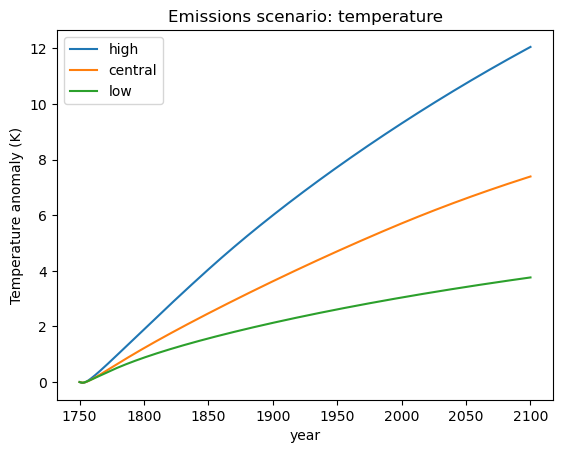

In [35]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='Emissions', layer=0)], label=f.configs)
plt.title('Emissions scenario: temperature')
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()

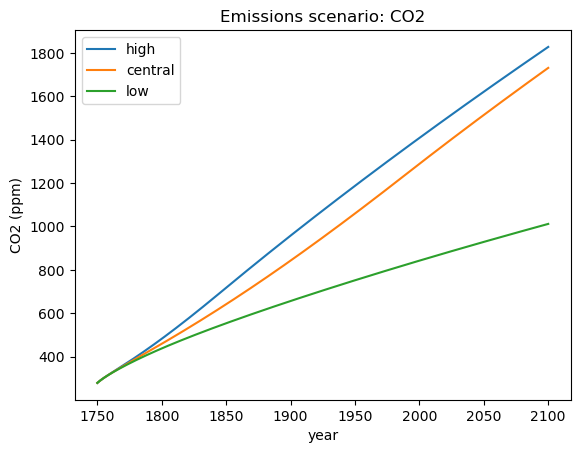

In [36]:
plt.plot(f.timebounds, f.concentration.loc[dict(scenario='Emissions', specie='CO2')], label=f.configs)
plt.title('Emissions scenario: CO2')
plt.xlabel('year')
plt.ylabel('CO2 (ppm)')
plt.legend()

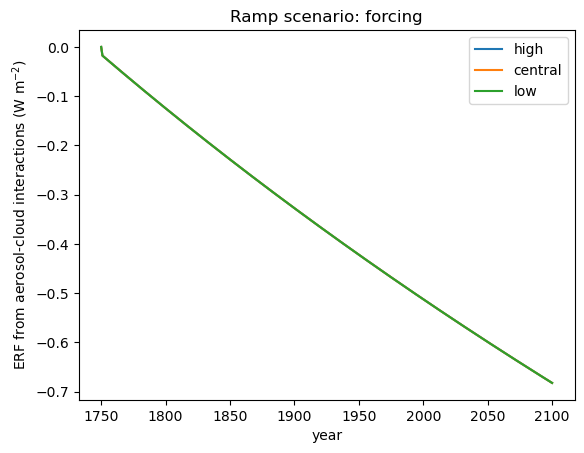

In [37]:
plt.plot(f.timebounds, f.forcing.loc[dict(scenario='SAI', specie='ERFaci')], label=f.configs)
plt.title('Ramp scenario: forcing')
plt.xlabel('year')
plt.ylabel('ERF from aerosol-cloud interactions (W m$^{-2}$)')
plt.legend()

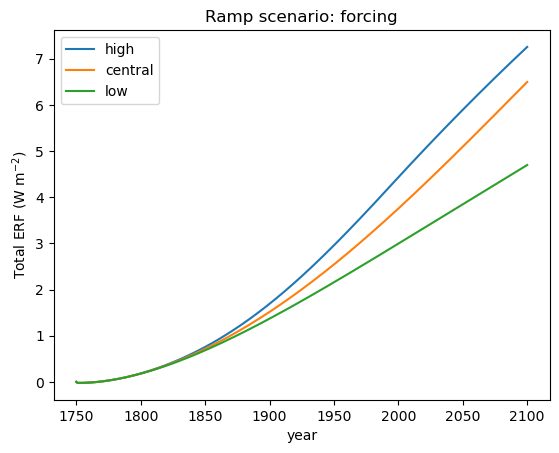

In [38]:
plt.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='SAI')], label=f.configs)
plt.title('Ramp scenario: forcing')
plt.xlabel('year')
plt.ylabel('Total ERF (W m$^{-2}$)')
plt.legend()

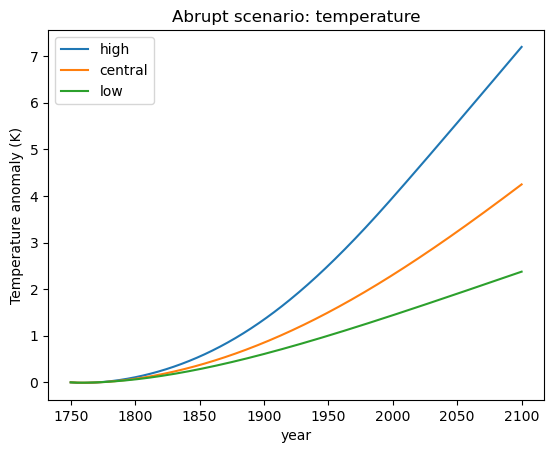

In [39]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='SAI', layer=0)], label=f.configs)
plt.title('Abrupt scenario: temperature')
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()

# Setting up SAI - configs used for model

In [93]:
import fair
import numpy as np
import os
import matplotlib.pyplot as plt
import xarray
import pandas as pd
fair.__version__

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year



In [94]:
data_path = '../data/example_github_data/'
volcano_df = pd.read_csv(os.path.join(data_path, 'volcano_forcing_data.csv'), index_col='year').drop(['Unnamed: 0'], axis=1).iloc[::6, :]
volcano_df

climate_df = pd.read_csv(os.path.join(data_path, 'climate_models_data.csv')).drop(['Unnamed: 0'], axis=1)
climate_df.head()

,model,run,conv,nit,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,CAMS-CSM1-0,r1i1p1f1,True,4809,28.239872,2.632439,9.262195,52.927697,1.876254,5.153591,0.643546,1.285458,2.690512,0.439493,8.870602
1,GISS-E2-2-G,r1i1p1f1,True,3965,2.385368,3.601142,11.333337,313.520678,1.972359,1.922481,0.631276,0.443575,0.544189,0.535407,8.035197
2,NorESM2-LM,r1i1p1f1,True,1966,1.633858,4.487727,125.070697,0.041775,1.603670,0.823165,1.596259,0.836880,1.343506,0.698845,7.845990
3,ACCESS-ESM1-5,r1i1p1f1,True,3517,2.742392,3.767727,8.922353,87.066320,0.699550,3.583351,0.842623,1.557784,0.636709,0.604740,6.557606
4,HadGEM3-GC31-LL,r1i1p1f3,True,5953,3.129576,3.868931,9.254582,66.399919,0.611179,2.851391,0.642237,1.174268,0.457505,0.611576,7.222087


In [95]:
f = FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
f.define_time(1750, 2100, 1/2) #timepoints, timebounds
f.define_scenarios(['ssp370'])
f.define_configs(['default', 'intervention'])
species, properties = read_properties()
f.define_species(species, properties)
num_entries = f.timebounds.size
f.allocate()

In [96]:
species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'BC',
 'OC',
 'NH3',
 'NOx',
 'VOC',
 'CO',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1202',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
 'NOx aviation',
 'Solar',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
 'Ozone',
 'Contrails',
 'Light absorbing particles on snow and ice',
 'Stratospheric water vapour',
 'Land use',
 'Equivalent effective stratospheric chlorine']

In [97]:
properties['Sulfur']

{'type': 'sulfur',
 'input_mode': 'emissions',
 'greenhouse_gas': False,
 'aerosol_chemistry_from_emissions': True,
 'aerosol_chemistry_from_concentration': False}

In [98]:
print(f.species)
print("\nAerosol chemistry forcers")
for key, value in properties.items():
    if value['aerosol_chemistry_from_emissions'] or value['aerosol_chemistry_from_concentration']:
        print(key, value['input_mode'])
    
    elif value['type']=='ari' or value['type']=='aci':
        print()
        print(key, value)

['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'NOx aviation', 'Solar', 'Volcanic', 'Aerosol-radiation interactions', 'Aerosol-cloud interactions', 'Ozone', 'Contrails', 'Light absorbing particles on snow and ice', 'Stratospheric water vapour', 'Land use', 'Equivalent effective stratospheric chlorine']

Aerosol chemistry forcers
CH4 emissions
N2O emissions
Sulfur emissions
BC emissions
OC emissions
NH3 emissions
NOx emissions
VOC emissions
CO emissions

Aerosol-radiation interactions {'type': 'ari', 'input_mo

In [99]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 2, specie: 64, gasbox: 4)
Coordinates:
  * config                                    (config) <U12 'default' 'interv...
  * specie                                    (specie) <U43 'CO2 FFI' ... 'Eq...
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.0 .....
    forcing_efficacy                          (config, specie) float64 1.0 .....
    forcing_temperature_feedback              (config, specie) float64 0.0 .....
    forcing_scale                             (config, specie) float64 1.0 .....
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0 .....
    cl_atoms                                  (specie) float64 0.0 0.0 ... 0.0
    br_atoms                                  (specie) float64 0.0 0.0 ... 0.0
    fractional_release                        (config, specie) float64 0.0 .....
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 nan .....
    lifetime_temperature_sensitivity          (config) float64 nan nan

# Fill in all data and parameters (to make actually climate-y)

In [100]:
# fill species configs using default values
f.fill_species_configs()
fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

In [101]:
# Use climate_df for climate configs. take the average of the first runs of all models to obtain climate params
averages = climate_df.drop_duplicates(subset=['model'], keep='first').mean(numeric_only=True)
fill(f.climate_configs['ocean_heat_capacity'], averages.loc['C1':'C3'].values)
fill(f.climate_configs['ocean_heat_transfer'], averages.loc['kappa1':'kappa3'].values)
fill(f.climate_configs['deep_ocean_efficacy'], averages['epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], averages['gamma'])
fill(f.climate_configs['sigma_eta'], averages['sigma_eta'])
fill(f.climate_configs['sigma_xi'], averages['sigma_xi'])
fill(f.climate_configs['stochastic_run'], True)
fill(f.climate_configs['use_seed'], True)
fill(f.climate_configs['seed'], 1355763)

f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 2, layer: 3)
Coordinates:
  * config                 (config) <U12 'default' 'intervention'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 1.115 2.507 ... 2.507 0.8351
    ocean_heat_capacity    (config, layer) float64 3.968 16.36 ... 16.36 108.1
    deep_ocean_efficacy    (config) float64 1.149 1.149
    stochastic_run         (config) bool True True
    sigma_eta              (config) float64 0.8897 0.8897
    sigma_xi               (config) float64 0.5519 0.5519
    gamma_autocorrelation  (config) float64 5.735 5.735
    seed                   (config) uint32 1355763 1355763
    use_seed               (config) bool True True
    forcing_4co2           (config) float64 8.0 8.0

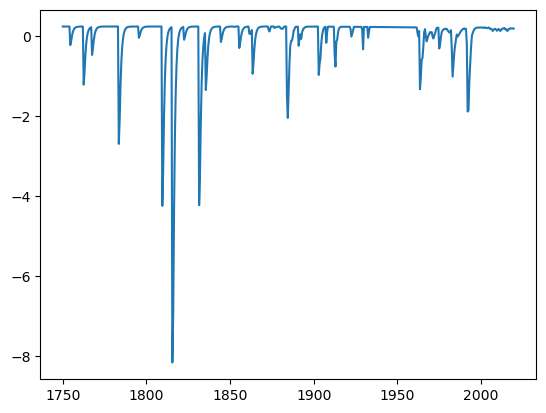

In [102]:
f.fill_from_rcmip()

volcanic_forcing = np.zeros(num_entries)
volcanic_forcing[:2*270] = volcano_df.squeeze().values
fill(f.forcing, volcanic_forcing[:, None, None], specie='Volcanic')
plt.plot(volcano_df.index, f.forcing.sel(specie='Volcanic').data[:540, 0, 0])
plt.show()

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

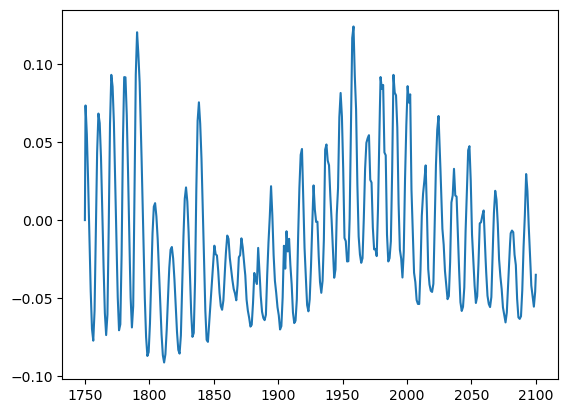

In [103]:
plt.plot(f.timebounds, f.forcing.sel(specie='Solar', scenario='ssp370', config='default'))

In [104]:
#which emissions species are not null?
for s in f.species:
    if np.isnan(f.emissions.sel(specie=s).data).all():
        print(s, f.properties[s]['input_mode'])
        


CO2 calculated
Solar forcing
Volcanic forcing
Aerosol-radiation interactions calculated
Aerosol-cloud interactions calculated
Ozone calculated
Contrails calculated
Light absorbing particles on snow and ice calculated
Stratospheric water vapour calculated
Land use calculated
Equivalent effective stratospheric chlorine calculated


In [105]:
#which forcing species are not null?
for s in f.species:
    if(not np.isnan(f.forcing.sel(specie=s).data[1:, 0, 0]).all()):
        print(s)

Solar
Volcanic


In [106]:
f.emissions

<xarray.DataArray (timepoints: 700, scenario: 1, config: 2, specie: 64)>
array([[[[9.50553406e-03, 2.96096484e-01,            nan, ...,
                     nan,            nan,            nan],
         [9.50553406e-03, 2.96096484e-01,            nan, ...,
                     nan,            nan,            nan]]],


       [[[9.50570573e-03, 2.98832730e-01,            nan, ...,
                     nan,            nan,            nan],
         [9.50570573e-03, 2.98832730e-01,            nan, ...,
                     nan,            nan,            nan]]],


       [[[9.50587739e-03, 3.01568976e-01,            nan, ...,
                     nan,            nan,            nan],
         [9.50587739e-03, 3.01568976e-01,            nan, ...,
                     nan,            nan,            nan]]],


       ...,


       [[[7.92234822e+01, 2.64016378e+00,            nan, ...,
                     nan,            nan,            nan],
         [7.92234822e+01, 2.64016378e+00,            nan, ...,
                     nan,            nan,            nan]]],


       [[[7.94652621e+01, 2.64472301e+00,            nan, ...,
                     nan,            nan,            nan],
         [7.94652621e+01, 2.64472301e+00,            nan, ...,
                     nan,            nan,            nan]]],


       [[[7.97070421e+01, 2.64928225e+00,            nan, ...,
                     nan,            nan,            nan],
         [7.97070421e+01, 2.64928225e+00,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.751e+03 ... 2.099e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

In [107]:
fair.structure.units.desired_emissions_units

{'CO2 FFI': 'Gt CO2/yr',
 'CO2 AFOLU': 'Gt CO2/yr',
 'CO2': 'Gt CO2/yr',
 'CH4': 'Mt CH4/yr',
 'N2O': 'Mt N2O/yr',
 'Sulfur': 'Mt SO2/yr',
 'BC': 'Mt BC/yr',
 'OC': 'Mt OC/yr',
 'NH3': 'Mt NH3/yr',
 'NOx': 'Mt NO2/yr',
 'VOC': 'Mt VOC/yr',
 'CO': 'Mt CO/yr',
 'CFC-11': 'kt CFC11/yr',
 'CFC-12': 'kt CFC12/yr',
 'CFC-113': 'kt CFC113/yr',
 'CFC-114': 'kt CFC114/yr',
 'CFC-115': 'kt CFC115/yr',
 'HCFC-22': 'kt HCFC22/yr',
 'HCFC-141b': 'kt HCFC141b/yr',
 'HCFC-142b': 'kt HCFC142b/yr',
 'CCl4': 'kt CCl4/yr',
 'CHCl3': 'kt CHCl3/yr',
 'CH2Cl2': 'kt CH2Cl2/yr',
 'CH3Cl': 'kt CH3Cl/yr',
 'CH3CCl3': 'kt CH3CCl3/yr',
 'CH3Br': 'kt CH3Br/yr',
 'Halon-1202': 'kt Halon1202/yr',
 'Halon-1211': 'kt Halon1211/yr',
 'Halon-1301': 'kt Halon1301/yr',
 'Halon-2402': 'kt Halon2402/yr',
 'CF4': 'kt CF4/yr',
 'C2F6': 'kt C2F6/yr',
 'C3F8': 'kt C3F8/yr',
 'c-C4F8': 'kt cC4F8/yr',
 'C4F10': 'kt C4F10/yr',
 'C5F12': 'kt C5F12/yr',
 'C6F14': 'kt C6F14/yr',
 'C7F16': 'kt C7F16/yr',
 'C8F18': 'kt C8F18/yr',
 'NF3

In [108]:
fair.structure.species.valid_input_modes

{'co2 ffi': ['emissions'],
 'co2 afolu': ['emissions'],
 'co2': ['emissions', 'calculated', 'concentration', 'forcing'],
 'ch4': ['emissions', 'concentration', 'forcing'],
 'n2o': ['emissions', 'concentration', 'forcing'],
 'cfc-11': ['emissions', 'concentration', 'forcing'],
 'other halogen': ['emissions', 'concentration', 'forcing'],
 'f-gas': ['emissions', 'concentration', 'forcing'],
 'sulfur': ['emissions'],
 'black carbon': ['emissions'],
 'organic carbon': ['emissions'],
 'other slcf': ['emissions'],
 'nox aviation': ['emissions'],
 'eesc': ['concentration', 'calculated'],
 'ozone': ['calculated', 'forcing'],
 'ari': ['calculated', 'forcing'],
 'aci': ['calculated', 'forcing'],
 'contrails': ['calculated', 'forcing'],
 'lapsi': ['calculated', 'forcing'],
 'h2o stratospheric': ['calculated', 'forcing'],
 'land use': ['calculated', 'forcing'],
 'volcanic': ['forcing'],
 'solar': ['forcing'],
 'unspecified': ['forcing']}

### Geoengineering

In [109]:
sul = f.emissions.sel(specie='Sulfur', config='intervention')
sul.loc[2023.25:, 'ssp370'] = sul.loc[2023.25:, 'ssp370'] + 240 
fill(f.emissions.sel(specie='Sulfur', config='intervention'), sul)
f.emissions.sel(specie='Sulfur')

<xarray.DataArray (timepoints: 700, scenario: 1, config: 2)>
array([[[  2.44796576,   2.44796576]],

       [[  2.43213111,   2.43213111]],

       [[  2.41629646,   2.41629646]],

       ...,

       [[ 79.10442708, 319.10442708]],

       [[ 78.83098454, 318.83098454]],

       [[ 78.55754199, 318.55754199]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.751e+03 ... 2.099e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    specie      <U43 'Sulfur'

In [110]:
emit = f.emissions.sel(specie='CO2 FFI', config='intervention')
emit.loc[2023.25:, 'ssp370'] = emit.loc[2023.25:, 'ssp370'] - 30
fill(f.emissions.sel(specie='CO2 FFI', config='intervention'), emit)
f.emissions.sel(specie='CO2 FFI')

<xarray.DataArray (timepoints: 700, scenario: 1, config: 2)>
array([[[9.50553406e-03, 9.50553406e-03]],

       [[9.50570573e-03, 9.50570573e-03]],

       [[9.50587739e-03, 9.50587739e-03]],

       ...,

       [[7.92234822e+01, 4.92234822e+01]],

       [[7.94652621e+01, 4.94652621e+01]],

       [[7.97070421e+01, 4.97070421e+01]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.751e+03 ... 2.099e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    specie      <U43 'CO2 FFI'

In [111]:
vars_sul = ['tropospheric_adjustment', 'forcing_efficacy',
       'forcing_temperature_feedback', 'forcing_scale', 'partition_fraction',
       'unperturbed_lifetime', 'molecular_weight', 'baseline_concentration',
       'iirf_0', 'iirf_airborne', 'iirf_uptake', 'iirf_temperature',
       'baseline_emissions', 'g0', 'g1', 'concentration_per_emission',
       'forcing_reference_concentration',
       'greenhouse_gas_radiative_efficiency', 'contrails_radiative_efficiency',
       'erfari_radiative_efficiency', 'h2o_stratospheric_factor',
       'lapsi_radiative_efficiency',
       'land_use_cumulative_emissions_to_forcing',
       'ozone_radiative_efficiency', 'aci_scale', 'aci_shape', 'cl_atoms',
       'br_atoms', 'fractional_release', 'ch4_lifetime_chemical_sensitivity',
       'lifetime_temperature_sensitivity']

In [112]:
sulfur_properties

<xarray.DataArray (variable: 31)>
array([ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
                   nan,             nan,  6.40690000e+01,             nan,
                   nan,             nan,             nan,             nan,
        2.44004844e+00,             nan,             nan,  8.80528033e-02,
                   nan,             nan,  0.00000000e+00, -2.86000000e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.03057237e+00,  1.69000000e-02,             nan,             nan,
                   nan,  0.00000000e+00, -4.08000000e-02])
Coordinates:
    config    <U12 'default'
    specie    <U43 'Sulfur'
    gasbox    int64 0
  * variable  (variable) object 'tropospheric_adjustment' ... 'lifetime_tempe...

In [113]:
sulfur_properties = f.species_configs.to_array().loc[:, 'default', 'Sulfur', 0]
res = ""
count = 0
for i in range(sulfur_properties.size):
    if(not sulfur_properties[i].isnull().item()):
        count += 1
        res = res + " ".join(vars_sul[i].split("_")) + ' & ' + str(sulfur_properties[i].item()) + ' \\\ \hline \n'


In [114]:
print(res)

tropospheric adjustment & 0.0 \\ \hline 
forcing efficacy & 1.0 \\ \hline 
forcing temperature feedback & 0.0 \\ \hline 
forcing scale & 1.0 \\ \hline 
molecular weight & 64.069 \\ \hline 
baseline emissions & 2.440048435 \\ \hline 
concentration per emission & 0.08805280331056461 \\ \hline 
contrails radiative efficiency & 0.0 \\ \hline 
erfari radiative efficiency & -0.00286 \\ \hline 
h2o stratospheric factor & 0.0 \\ \hline 
lapsi radiative efficiency & 0.0 \\ \hline 
land use cumulative emissions to forcing & 0.0 \\ \hline 
ozone radiative efficiency & 0.0 \\ \hline 
aci scale & -1.03057237 \\ \hline 
aci shape & 0.0169 \\ \hline 
ch4 lifetime chemical sensitivity & 0.0 \\ \hline 
lifetime temperature sensitivity & -0.0408 \\ \hline 



# Run and Analyze

In [115]:
f.run()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1138.48timestep


In [116]:
# We care about:
print('Temperature: ', f.temperature.shape)
print('Concentrations: ', f.concentration.shape)
print('Forcing_sum: ', f.forcing_sum.shape)

Temperature:  (701, 1, 2, 3)
Concentrations:  (701, 1, 2, 64)
Forcing_sum:  (701, 1, 2)


In [117]:
f.temperature.sel(layer=0, scenario='ssp370') #surface

<xarray.DataArray (timebounds: 701, config: 2)>
array([[ 0.        ,  0.        ],
       [-0.09984668, -0.09984668],
       [ 0.06933374,  0.06933374],
       ...,
       [ 4.57477641,  2.65910706],
       [ 4.57303906,  2.65105059],
       [ 4.59074881,  2.66246885]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.75e+03 ... 2.1e+03 2.1e+03
    scenario    <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    layer       int64 0

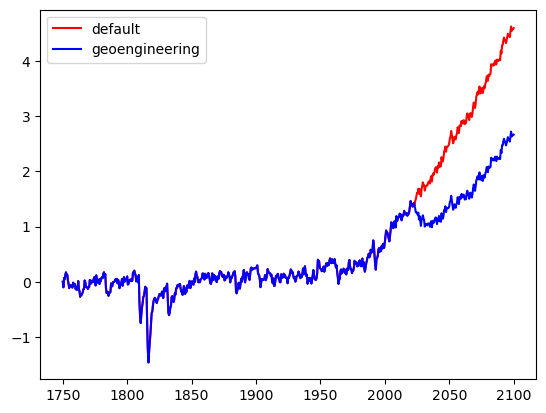

In [119]:
plt.plot(f.timebounds, f.temperature.sel(layer=0, scenario='ssp370', config='default'), color='r', label='default')
plt.plot(f.timebounds, f.temperature.sel(layer=0, scenario='ssp370', config='intervention'), color='blue', label='geoengineering')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.show()

Text(0, 0.5, 'Temperature anomaly (K)')

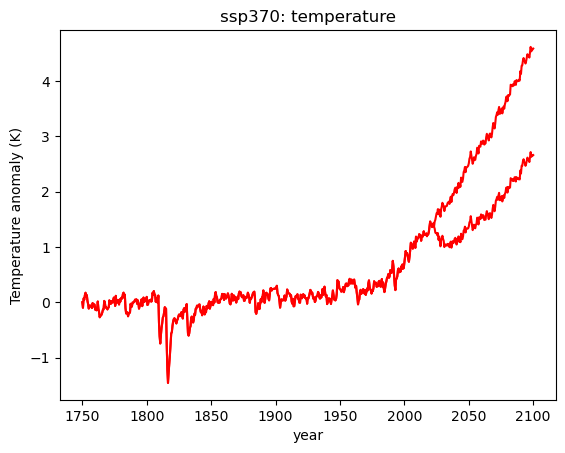

In [27]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp370', layer=0)], label=f.configs, color='r');
plt.title('ssp370: temperature')
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'methane lifetime (yr)')

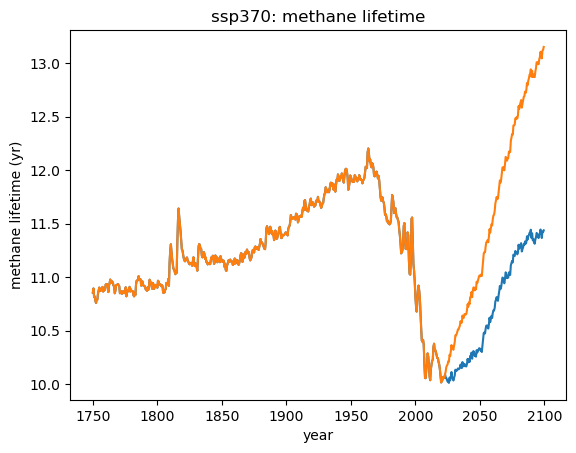

In [28]:
plt.plot(f.timebounds, f.species_configs['unperturbed_lifetime'].loc[dict(specie='CH4', gasbox=0)].data * f.alpha_lifetime.loc[dict(scenario='ssp370', specie='CH4')], label=f.configs);
plt.title('ssp370: methane lifetime')
plt.xlabel('year')
plt.ylabel('methane lifetime (yr)')

Text(0, 0.5, 'W/m2')

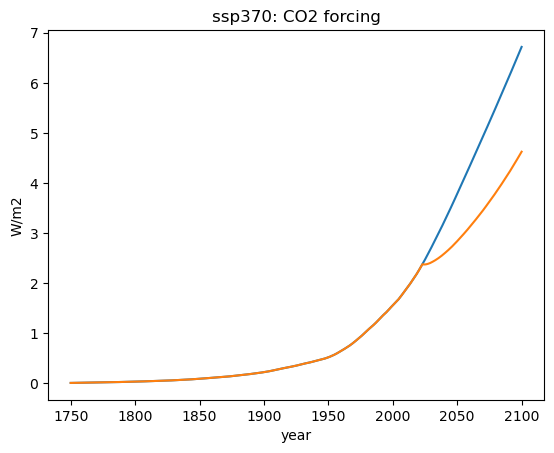

In [29]:
plt.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='CO2')], label=f.configs);
plt.title('ssp370: CO2 forcing')
plt.xlabel('year')
plt.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

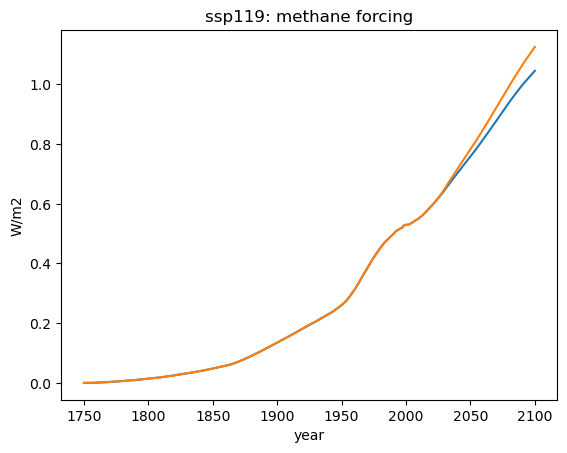

In [30]:
plt.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='CH4')], label=f.configs);
plt.title('ssp119: methane forcing')
plt.xlabel('year')
plt.ylabel('W/m2')

In [32]:
f.forcing.loc[dict(scenario='ssp370', specie='Sulfur')]

<xarray.DataArray (timebounds: 701, config: 2)>
array([[ 0.,  0.],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.75e+03 ... 2.1e+03 2.1e+03
    scenario    <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    specie      <U43 'Sulfur'

Text(0, 0.5, 'W/m2')

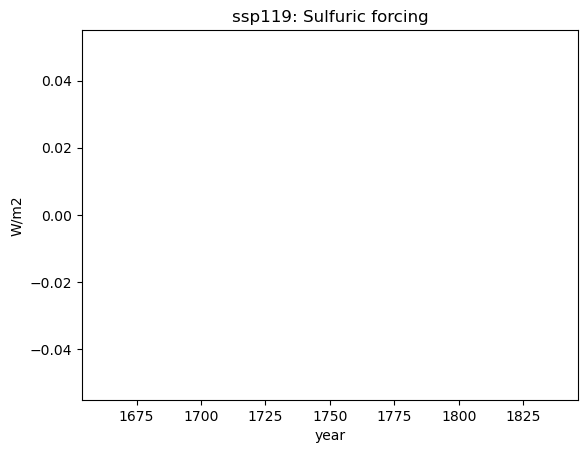

In [31]:
plt.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='Sulfur')], label=f.configs);
plt.title('ssp119: Sulfuric forcing')
plt.xlabel('year')
plt.ylabel('W/m2')

In [23]:
f.forcing.sel(specie='Sulfur')

<xarray.DataArray (timebounds: 701, scenario: 1, config: 2)>
array([[[ 0.,  0.]],

       [[nan, nan]],

       [[nan, nan]],

       ...,

       [[nan, nan]],

       [[nan, nan]],

       [[nan, nan]]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.75e+03 ... 2.1e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    specie      <U43 'Sulfur'

In [24]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='Aerosol-radiation interactions')], label=f.configs);
pl.title('ssp119: ERFari')
pl.xlabel('year')
pl.ylabel('W/m2')

NameError: name 'pl' is not defined

Text(0, 0.5, 'W/m2')

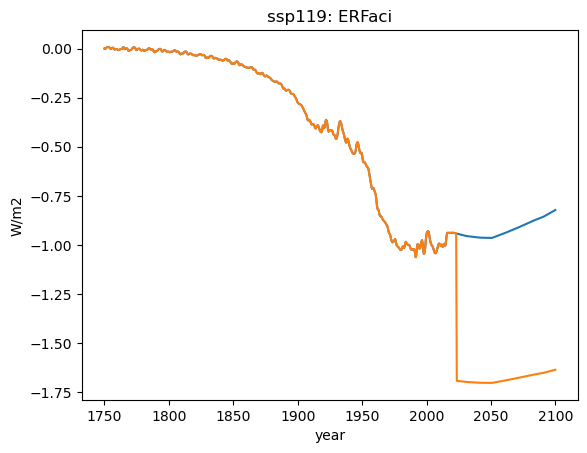

In [34]:
plt.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='Aerosol-cloud interactions')], label=f.configs);
plt.title('ssp119: ERFaci')
plt.xlabel('year')
plt.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

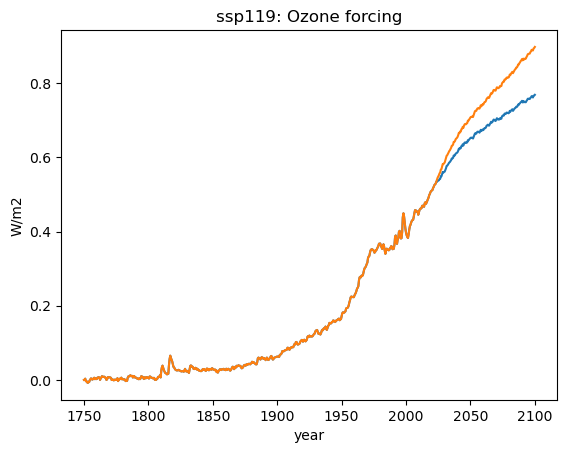

In [35]:
plt.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='Ozone')], label=f.configs);
plt.title('ssp119: Ozone forcing')
plt.xlabel('year')
plt.ylabel('W/m2')

In [41]:
f.configs

['default', 'intervention']

In [52]:
f.concentration.loc[2023, 'ssp370', 'intervention', 'Sulfur'].item()


nan

In [59]:
f.scenarios

['ssp370']

In [75]:
f.forcing.loc[2023, 'ssp370', 'intervention', 'Sulfur']

<xarray.DataArray ()>
array(nan)
Coordinates:
    timebounds  float64 2.023e+03
    scenario    <U6 'ssp370'
    config      <U12 'intervention'
    specie      <U43 'Sulfur'

In [78]:
f.forcing_sum.loc[2023, 'ssp370', 'intervention'].item()

2.9935166662335932

# Test a Re-Run with altered parameters (verify consistency)

In [1]:
import fair
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import xarray
import pandas as pd
fair.__version__

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_path = '../data/example_github_data/'
volcano_df = pd.read_csv(os.path.join(data_path, 'volcano_forcing_data.csv'), index_col='year').drop(['Unnamed: 0'], axis=1)
volcano_df

climate_df = pd.read_csv(os.path.join(data_path, 'climate_models_data.csv')).drop(['Unnamed: 0'], axis=1)
averages = climate_df.drop_duplicates(subset=['model'], keep='first').mean(numeric_only=True)

species, properties = read_properties()


def setup_model(end_year=2105, scenario='ssp245', timesteps_per_year=1):
    
    # consider fiddling with sulfur properties since forcing seems weak and f.forcing does not include sulfur
    
    f = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    f.define_time(1750, end_year, 1/timesteps_per_year) #timepoints, timebounds
    f.define_scenarios([scenario])
    f.define_configs(['default', 'intervention'])
    f.define_species(species, properties)
    f.timesteps_per_year = timesteps_per_year
    f.allocate()

    # fill species configs using default values
    f.fill_species_configs()
    fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

    # Use climate_df for climate configs. take the average of the first runs of all models to obtain climate params
    fill(f.climate_configs['ocean_heat_capacity'], averages.loc['C1':'C3'].values)
    fill(f.climate_configs['ocean_heat_transfer'], averages.loc['kappa1':'kappa3'].values)
    fill(f.climate_configs['deep_ocean_efficacy'], averages['epsilon'])
    fill(f.climate_configs['gamma_autocorrelation'], averages['gamma'])
    fill(f.climate_configs['sigma_eta'], averages['sigma_eta'])
    fill(f.climate_configs['sigma_xi'], averages['sigma_xi'])
    fill(f.climate_configs['stochastic_run'], True)
    fill(f.climate_configs['use_seed'], True)
    fill(f.climate_configs['seed'], 1355763)

    f.fill_from_rcmip()

    volcanic_forcing = np.zeros(f.timebounds.size)
    volcanic_forcing[:timesteps_per_year*270] = volcano_df.iloc[::int(12/timesteps_per_year)].squeeze().values
    fill(f.forcing, volcanic_forcing[:, None, None], specie='Volcanic')

    initialise(f.concentration, f.species_configs['baseline_concentration'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    
    return(f)

In [6]:
def xequals(d1, d2):
    assert type(d1) == type(d2), "Type mismatch"
    if(type(d1) == xarray.core.dataset.Dataset):
        a = np.nan_to_num(d1.to_array())
        b = np.nan_to_num(d2.to_array())
    elif(type(d1) == xarray.core.dataarray.DataArray):
        a = np.nan_to_num(d1.data)
        b = np.nan_to_num(d2.data)
    return(np.array_equal(a, b))

In [25]:
f = setup_model()
species_configs = f.species_configs.copy(deep=True)
climate_configs = f.climate_configs.copy(deep=True)
emissions = f.emissions.copy(deep=True)
concentration = f.concentration.copy(deep=True)
forcing = f.forcing.copy(deep=True)
forcing_sum = f.forcing_sum.copy(deep=True)
temperature = f.temperature.copy(deep=True)
cumulative_emissions = f.cumulative_emissions.copy(deep=True)
airborne_emissions = f.airborne_emissions.copy(deep=True)
airborne_fraction = f.airborne_fraction.copy(deep=True)
ocean_heat_content_change = f.ocean_heat_content_change.copy(deep=True)
stochastic_forcing = f.stochastic_forcing.copy(deep=True)
toa_imbalance = f.toa_imbalance.copy(deep=True)

def reset():
    t1 = time.time()
    g = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    g.define_time(1750, 2105, 1) #timepoints, timebounds
    g.define_scenarios(['ssp245'])
    g.define_configs(['default', 'intervention'])
    g.define_species(species, properties)
    g.allocate()
    t2 = time.time()
    print(t2-t1)
    g.species_configs = species_configs
    g.climate_configs = climate_configs
    g.emissions = emissions
    g.concentration = concentration
    g.forcing = forcing
    g.forcing_sum = forcing_sum
    g.temperature = temperature
    g.cumulative_emissions = cumulative_emissions
    g.airborne_emissions = airborne_emissions
    g.airborne_fraction = airborne_fraction
    g.ocean_heat_content_change = ocean_heat_content_change
    g.stochastic_forcing = stochastic_forcing
    g.toa_imbalance = toa_imbalance
    print(time.time()-t2)
    return(g)

/var/folders/lc/mjy2_vc10zd7k8yny4sjghbr0000gn/T/ipykernel_32924/670334512.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


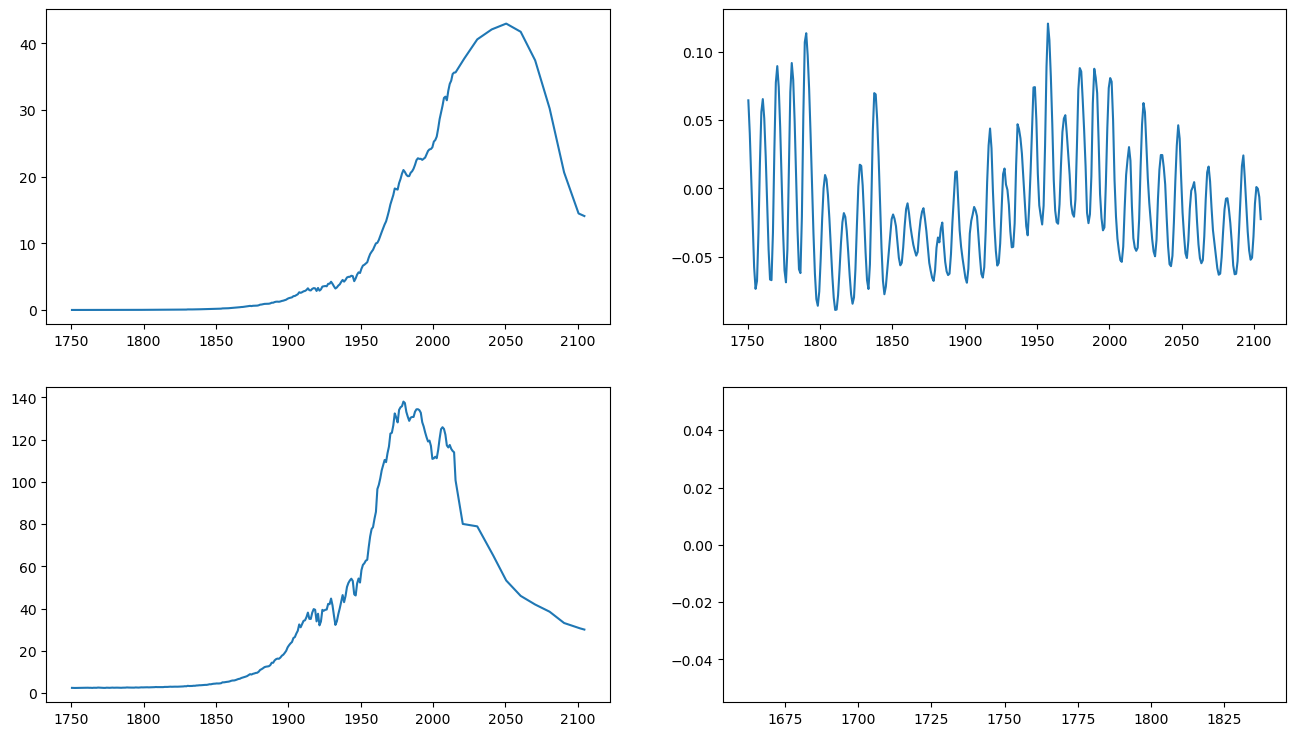

In [13]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(f.timepoints, f.emissions[:, 0, 0, 0])
ax2.plot(f.timepoints, f.forcing[1:, 0, 0, :].loc[:, 'Solar'])
ax3.plot(f.timepoints, f.emissions[:, 0, 0, :].loc[:, 'Sulfur'])
ax4.plot(f.timebounds, f.temperature[:, 0, 0, 0])

fig.show()

In [26]:
f.run()

Running 2 projections in parallel: 100%|█| 355/355 [00:00<00:00, 1153.74timestep


In [28]:
s = time.time()
f = reset()
time.time() - s

0.025838851928710938
0.00015091896057128906


0.026200056076049805

In [22]:
access_state(f, 2023)

[2023,
 1.6639810013301723,
 41.21323642769785,
 79.85157962172558,
 423.79606913089515,
 3.031367280242108]

In [153]:
access_state(f, 2023)

[2023,
 1.6639810013301723,
 41.21323642769785,
 79.85157962172558,
 423.79606913089515,
 3.031367280242108]

In [18]:
def access_state(model, year):
    return([
        year, 
        model.temperature.loc[year, model.scenarios[0], model.configs[1], 0].item(),
        model.emissions.loc[year - 0.5, model.scenarios[0], model.configs[1], :][:2].sum().item(),
        model.emissions.loc[year - 0.5, model.scenarios[0], model.configs[1], 'Sulfur'].item(),
        model.concentration.loc[year, model.scenarios[0], model.configs[1], 'CO2'].item(),
        model.forcing_sum.loc[year, model.scenarios[0], model.configs[1]].item()
    ])

In [51]:
year = 2023
f1.temperature.loc[year, f1.scenarios[0], f1.configs[1], 0]

<xarray.DataArray ()>
array(1.663981)
Coordinates:
    timebounds  float64 2.023e+03
    scenario    <U6 'ssp245'
    config      <U12 'intervention'
    layer       int64 0

In [14]:
scenario = f1.scenarios[0]

f1 = setup_model()
f1.run()

year = 2023                    
[
    year, 
    f1.temperature.loc[year, scenario, f1.configs[1], 0].item(),
    f1.emissions.loc[year+0.5, scenario, f1.configs[1], :][:2].sum().item(),
    f1.emissions.loc[year+0.5, scenario, f1.configs[1], 'Sulfur'].item(),
    f1.concentration.loc[year, scenario, f1.configs[1], 'CO2'].item(),
    f1.forcing_sum.loc[year, scenario, f1.configs[1]].item()
]

Running 2 projections in parallel: 100%|█| 355/355 [00:00<00:00, 1495.40timestep


[2023,
 1.6639810013301723,
 41.49608969329396,
 79.73681623109796,
 423.79606913089515,
 3.031367280242108]

In [24]:
f1.configs

['default', 'intervention']

In [45]:
year = 2023
emissions = f1.emissions.loc[:, f1.scenarios[0], f1.configs[1], :]
emissions.loc[year + 0.5, 'Sulfur'] = emissions.loc[year - 0.5, 'CO2 FFI'] +3
f1.emissions.loc[:, f1.scenarios[0], f1.configs[1], :] = emissions

In [48]:
f1.emissions.loc[2022.5:2023.5, f1.scenarios[0], f1.configs[1], 'Sulfur']

<xarray.DataArray (timepoints: 2)>
array([79.85157962, 79.73681623])
Coordinates:
  * timepoints  (timepoints) float64 2.022e+03 2.024e+03
    scenario    <U6 'ssp245'
    config      <U12 'intervention'
    specie      <U43 'Sulfur'

In [42]:
f1.timepoints

array([1750.5, 1751.5, 1752.5, 1753.5, 1754.5, 1755.5, 1756.5, 1757.5,
       1758.5, 1759.5, 1760.5, 1761.5, 1762.5, 1763.5, 1764.5, 1765.5,
       1766.5, 1767.5, 1768.5, 1769.5, 1770.5, 1771.5, 1772.5, 1773.5,
       1774.5, 1775.5, 1776.5, 1777.5, 1778.5, 1779.5, 1780.5, 1781.5,
       1782.5, 1783.5, 1784.5, 1785.5, 1786.5, 1787.5, 1788.5, 1789.5,
       1790.5, 1791.5, 1792.5, 1793.5, 1794.5, 1795.5, 1796.5, 1797.5,
       1798.5, 1799.5, 1800.5, 1801.5, 1802.5, 1803.5, 1804.5, 1805.5,
       1806.5, 1807.5, 1808.5, 1809.5, 1810.5, 1811.5, 1812.5, 1813.5,
       1814.5, 1815.5, 1816.5, 1817.5, 1818.5, 1819.5, 1820.5, 1821.5,
       1822.5, 1823.5, 1824.5, 1825.5, 1826.5, 1827.5, 1828.5, 1829.5,
       1830.5, 1831.5, 1832.5, 1833.5, 1834.5, 1835.5, 1836.5, 1837.5,
       1838.5, 1839.5, 1840.5, 1841.5, 1842.5, 1843.5, 1844.5, 1845.5,
       1846.5, 1847.5, 1848.5, 1849.5, 1850.5, 1851.5, 1852.5, 1853.5,
       1854.5, 1855.5, 1856.5, 1857.5, 1858.5, 1859.5, 1860.5, 1861.5,
      

In [23]:
f1.emissions

<xarray.DataArray (timepoints: 355, scenario: 1, config: 2, specie: 64)>
array([[[[ 9.50561989e-03,  2.97464607e-01,  3.06970226e-01, ...,
                      nan,             nan,             nan],
         [ 9.50561989e-03,  2.97464607e-01,  3.06970226e-01, ...,
                      nan,             nan,             nan]]],


       [[[ 9.50596323e-03,  3.02937099e-01,  3.12443062e-01, ...,
                      nan,             nan,             nan],
         [ 9.50596323e-03,  3.02937099e-01,  3.12443062e-01, ...,
                      nan,             nan,             nan]]],


       [[[ 9.51000204e-03,  3.08510269e-01,  3.18020271e-01, ...,
                      nan,             nan,             nan],
         [ 9.51000204e-03,  3.08510269e-01,  3.18020271e-01, ...,
                      nan,             nan,             nan]]],


       ...,


       [[[ 1.42898300e+01, -4.60807389e+00,  9.68175606e+00, ...,
                      nan,             nan,             nan],
         [ 1.42898300e+01, -4.60807389e+00,  9.68175606e+00, ...,
                      nan,             nan,             nan]]],


       [[[ 1.41932770e+01, -4.51207235e+00,  9.68120470e+00, ...,
                      nan,             nan,             nan],
         [ 1.41932770e+01, -4.51207235e+00,  9.68120470e+00, ...,
                      nan,             nan,             nan]]],


       [[[ 1.40967241e+01, -4.41607081e+00,  9.68065333e+00, ...,
                      nan,             nan,             nan],
         [ 1.40967241e+01, -4.41607081e+00,  9.68065333e+00, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.104e+03 2.104e+03
  * scenario    (scenario) <U6 'ssp245'
  * config      (config) <U12 'default' 'intervention'
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

In [175]:
sul = f1.emissions.sel(specie='Sulfur', config='intervention')
sul.loc[2023.25:, 'ssp370'] = sul.loc[2023.25:, 'ssp370'] + 240 
fill(f1.emissions.sel(specie='Sulfur', config='intervention'), sul)
f1.emissions.sel(specie='Sulfur')

emit = f1.emissions.sel(specie='CO2 FFI', config='intervention')
emit.loc[2023.25:, 'ssp370'] = emit.loc[2023.25:, 'ssp370'] - 30
fill(f1.emissions.sel(specie='CO2 FFI', config='intervention'), emit)
f1.emissions.sel(specie='CO2 FFI')

<xarray.DataArray (timepoints: 700, scenario: 1, config: 2)>
array([[[  2.44796576,   2.44796576]],

       [[  2.43213111,   2.43213111]],

       [[  2.41629646,   2.41629646]],

       ...,

       [[ 79.10442708, 319.10442708]],

       [[ 78.83098454, 318.83098454]],

       [[ 78.55754199, 318.55754199]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.751e+03 ... 2.099e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    specie      <U43 'Sulfur'

In [176]:
emit = f1.emissions.sel(specie='CO2 FFI', config='intervention')
emit.loc[2023.25:, 'ssp370'] = emit.loc[2023.25:, 'ssp370'] - 30
fill(f1.emissions.sel(specie='CO2 FFI', config='intervention'), emit)
f1.emissions.sel(specie='CO2 FFI')

<xarray.DataArray (timepoints: 700, scenario: 1, config: 2)>
array([[[9.50553406e-03, 9.50553406e-03]],

       [[9.50570573e-03, 9.50570573e-03]],

       [[9.50587739e-03, 9.50587739e-03]],

       ...,

       [[7.92234822e+01, 4.92234822e+01]],

       [[7.94652621e+01, 4.94652621e+01]],

       [[7.97070421e+01, 4.97070421e+01]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.751e+03 ... 2.099e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U12 'default' 'intervention'
    specie      <U43 'CO2 FFI'

In [177]:
f1.run()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1500.53timestep


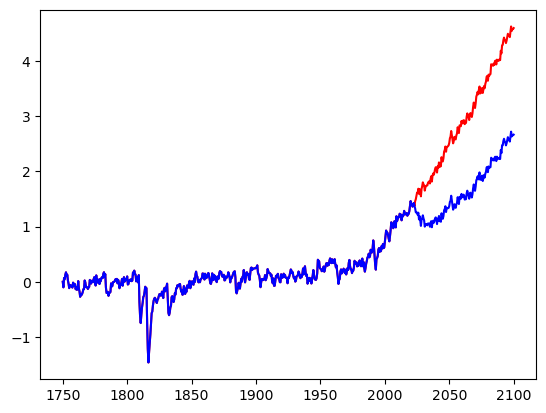

In [179]:
plt.plot(f1.timebounds, f1.temperature.sel(layer=0, scenario='ssp370', config='default'), color='r')
plt.plot(f1.timebounds, f1.temperature.sel(layer=0, scenario='ssp370', config='intervention'), color='blue')
plt.show()

In [114]:
f1.species_configs.sel(specie='Sulfur')

<xarray.Dataset>
Dimensions:                                   (config: 2, gasbox: 4)
Coordinates:
  * config                                    (config) <U16 'default' 'aersol...
    specie                                    <U43 'Sulfur'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config) float64 0.0 0.0
    forcing_efficacy                          (config) float64 1.0 1.0
    forcing_temperature_feedback              (config) float64 0.0 0.0
    forcing_scale                             (config) float64 1.0 1.0
    partition_fraction                        (config, gasbox) float64 nan .....
    unperturbed_lifetime                      (config, gasbox) float64 nan .....
    ...                                        ...
    aci_shape                                 (config) float64 0.0169 0.0169
    cl_atoms                                  float64 nan
    br_atoms                                  float64 nan
    fractional_release                        (config) float64 nan nan
    ch4_lifetime_chemical_sensitivity         (config) float64 0.0 0.0
    lifetime_temperature_sensitivity          (config) float64 -0.0408 -0.0408

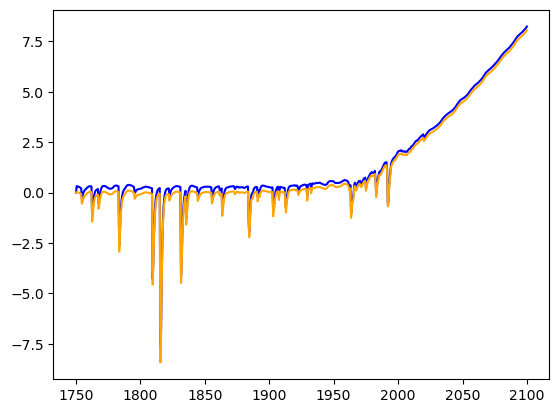

In [112]:
plt.plot(f1.timebounds, f1.forcing_sum[:, 0, 0], color='b')
plt.plot(f1.timebounds, f1.forcing_sum[:, 0, 1], color='orange')
plt.show()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1175.15timestep


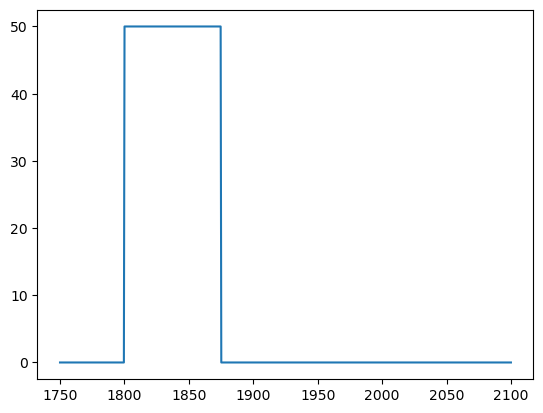

In [82]:
f2 = setup_model()
pulse_emit = np.zeros(f1.timepoints.size)
pulse_emit[100:250]=50
fill(f2.emissions.sel(specie='CO2 FFI'), pulse_emit[:, None, None])
plt.plot(f1.timepoints, f2.emissions.sel(specie='CO2 FFI').data[:, 0, 0])
f2.run()

In [56]:
f2.emissions = f1.emissions
f2.concentration = f1.concentration
f2.forcing = f1.forcing
f2.temperature = f1.temperature
f2.cumulative_emissions = f1.cumulative_emissions
f2.airborne_emissions = f1.airborne_emissions
f2.airborne_fraction = f1.airborne_fraction
f2.ocean_heat_content_change = f1.ocean_heat_content_change
f2.stochastic_forcing = f1.stochastic_forcing
f2.toa_imbalance = f1.toa_imbalance

f2.run()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1168.72timestep


In [57]:
f1.run()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1171.50timestep


In [51]:
f3 = setup_model()
f3.run()
pulse_emit = np.zeros(f1.timepoints.size)
pulse_emit[100:250]=50
fill(f3.emissions.sel(specie='CO2 FFI'), pulse_emit[:, None, None])

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1184.85timestep


Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1180.55timestep


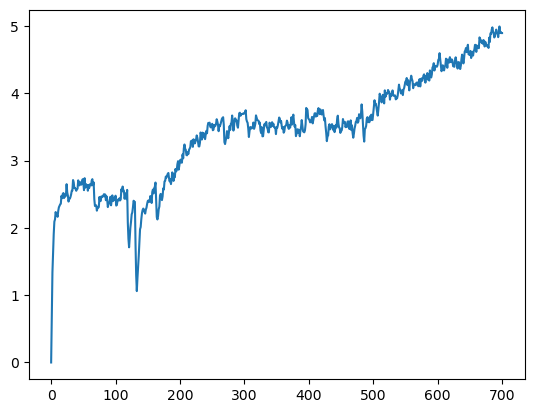

In [42]:
f3.run()
plt.plot(f3.temperature.sel(layer=0, scenario='ssp370', config='default'))

In [48]:
id(f3)

6482061456

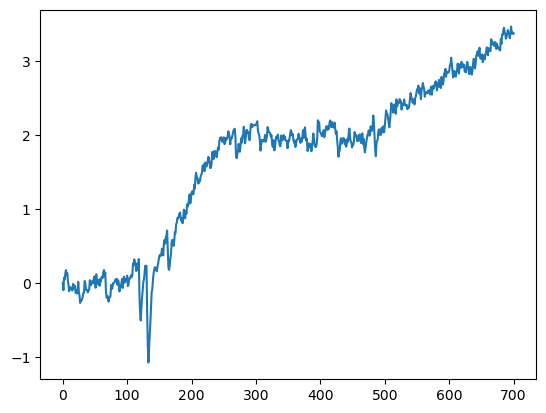

In [39]:
plt.plot(f2.temperature.sel(layer=0, scenario='ssp370', config='default'))

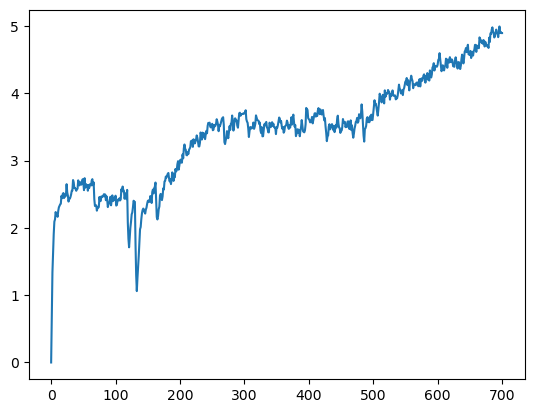

In [36]:
plt.plot(f2.temperature.sel(layer=0, scenario='ssp370', config='default'))

In [72]:
f2.emissions.sel(specie='Sulfur', scenario='ssp370', config='default', timepoints=2021.25)

<xarray.DataArray ()>
array(98.6486129)
Coordinates:
    timepoints  float64 2.021e+03
    scenario    <U6 'ssp370'
    config      <U16 'default'
    specie      <U43 'Sulfur'

In [73]:
f2.stochastic_forcing #f1 is all nan

<xarray.DataArray (timebounds: 701, scenario: 1, config: 2)>
array([[[0.        , 0.        ]],

       [[0.44659663, 0.44659663]],

       [[0.5396498 , 0.5396498 ]],

       ...,

       [[7.97862084, 7.97862084]],

       [[7.99798507, 7.99798507]],

       [[8.31049082, 8.31049082]]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.75e+03 ... 2.1e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp370'
  * config      (config) <U16 'default' 'aersol_injection'

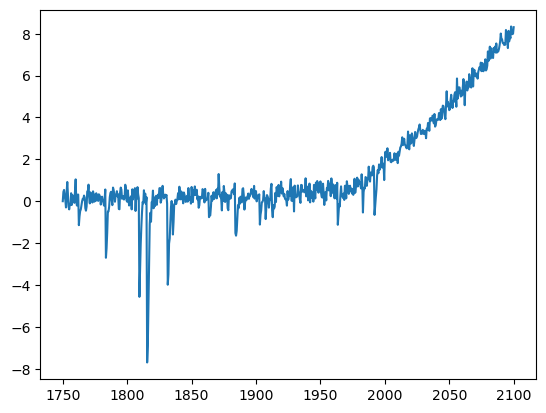

In [75]:
plt.plot(f2.timebounds, f2.stochastic_forcing.sel(scenario='ssp370', config='default'))

In [55]:
print("Species configs same: ", xequals(f1.species_configs, f2.species_configs))
print("Climate configs: ", xequals(f1.climate_configs, f2.climate_configs))
print("Stochastic Forcing: ", xequals(f1.stochastic_forcing, f2.stochastic_forcing))
print("Emissions: ", xequals(f1.emissions, f2.emissions))
print("Concentration: ", xequals(f1.concentration, f2.concentration))
print("Forcing: ", xequals(f1.forcing, f2.forcing))
print("temperature ", xequals(f1.temperature, f2.temperature))
print("Cumulative emissions and airborne emissions: ", xequals(f2.cumulative_emissions, f1.cumulative_emissions), xequals(f2.airborne_emissions, f1.airborne_emissions))
print("ocean_heat_content_change: ", xequals(f2.ocean_heat_content_change, f1.ocean_heat_content_change))
print("toa_imbalance: ", xequals(f2.toa_imbalance, f1.toa_imbalance))

Species configs same:  True
Climate configs:  True
Stochastic Forcing:  False
Emissions:  False
Concentration:  False
Forcing:  False
temperature  False
Cumulative emissions and airborne emissions:  False False
ocean_heat_content_change:  False
toa_imbalance:  False


In [ ]:
print(f1.stochastic_forcing)

In [47]:
f1.species_configs.sel(config='default', specie='Sulfur')

<xarray.Dataset>
Dimensions:                                   (gasbox: 4)
Coordinates:
    config                                    <U16 'default'
    specie                                    <U43 'Sulfur'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   float64 0.0
    forcing_efficacy                          float64 1.0
    forcing_temperature_feedback              float64 0.0
    forcing_scale                             float64 1.0
    partition_fraction                        (gasbox) float64 nan nan nan nan
    unperturbed_lifetime                      (gasbox) float64 nan nan nan nan
    ...                                        ...
    aci_shape                                 float64 0.0169
    cl_atoms                                  float64 nan
    br_atoms                                  float64 nan
    fractional_release                        float64 nan
    ch4_lifetime_chemical_sensitivity         float64 0.0
    lifetime_temperature_sensitivity          float64 -0.0408

In [41]:
f2.emissions.sel(specie='CO2', config='default', scenario='ssp370', timepoints=1750.25)

<xarray.DataArray ()>
array(0.30560202)
Coordinates:
    timepoints  float64 1.75e+03
    scenario    <U6 'ssp370'
    config      <U16 'default'
    specie      <U43 'CO2'

In [79]:
xequals(f1.toa_imbalance, f2.toa_imbalance)

False

In [66]:
time.time()

1672211619.364081

In [80]:
time.time()

1672211638.607593

In [83]:
start = time.time()
f2.emissions = f1.emissions
f2.concentration = f1.concentration
f2.forcing = f1.forcing
f2.temperature = f1.temperature
f2.cumulative_emissions = f1.cumulative_emissions
f2.airborne_emissions = f1.airborne_emissions
f2.airborne_fraction = f1.airborne_fraction
f2.ocean_heat_content_change = f1.ocean_heat_content_change
f2.stochastic_forcing = f1.stochastic_forcing
f2.toa_imbalance = f1.toa_imbalance
time.time() - start

0.0010628700256347656

In [84]:
start = time.time()
f = setup_model()
time.time() - start

2.0366668701171875

In [9]:
emit = np.zeros((700,1))
emit[200:] = 30

fill(f1.emissions.sel(specie='CO2'), emit[:, None])
fill(f1.emissions.sel(specie='CO2 AFOLU'), emit[:, None])
fill(f1.emissions.sel(specie='Sulfur'), emit[:, None])

fill(f2.emissions.sel(specie='CO2'), emit[:, None])
fill(f2.emissions.sel(specie='CO2 AFOLU'), emit[:, None])
fill(f2.emissions.sel(specie='Sulfur'), emit[:, None])

In [11]:
f1.run()
f2.run()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1064.49timestep
Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1098.90timestep


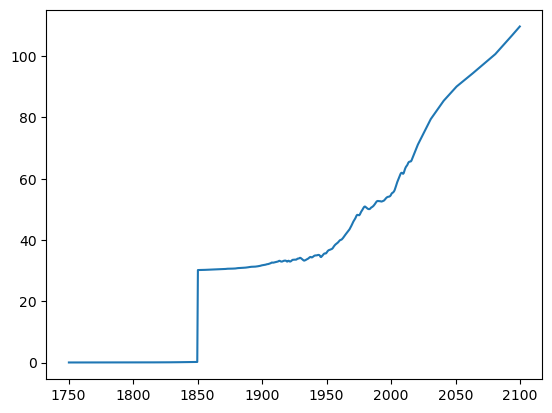

In [19]:
plt.plot(f1.timepoints, f1.emissions.sel(specie='CO2')[:, 0, 0])

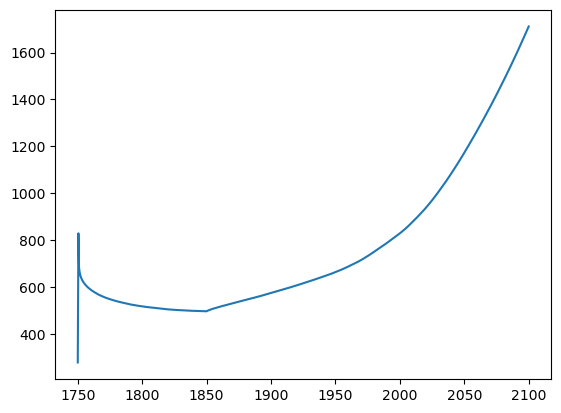

In [20]:
plt.plot(f1.timebounds, f1.concentration.sel(specie='CO2')[:, 0, 0])

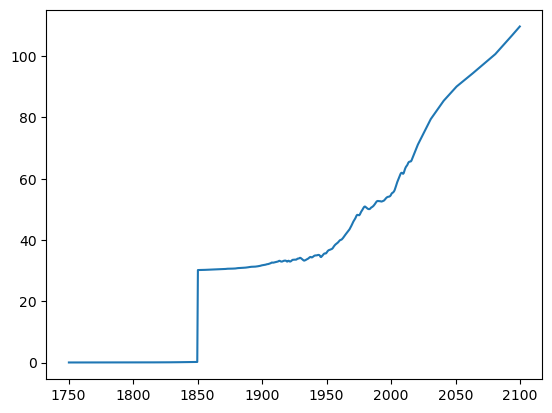

In [13]:
plt.plot(f2.timepoints, f2.emissions.sel(specie='CO2')[:, 0, 0])

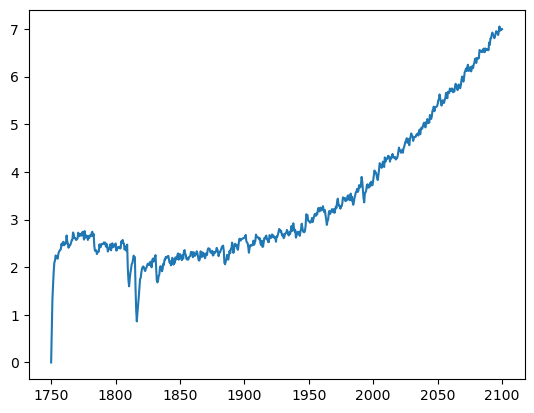

In [16]:
plt.plot(f1.timebounds, f1.temperature.sel(layer=0, scenario='ssp370')[:, 0])

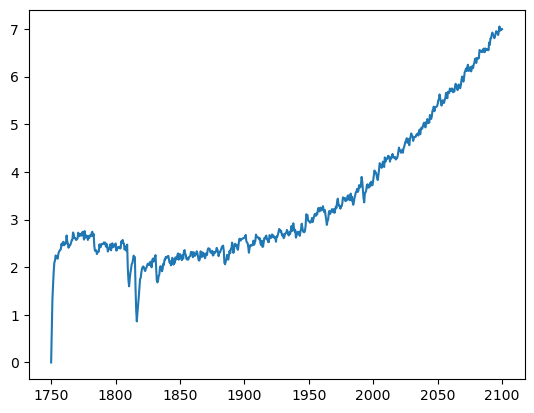

In [15]:
plt.plot(f2.timebounds, f2.temperature.sel(layer=0, scenario='ssp370')[:, 0])

In [110]:
time.time()

1672110766.714855

In [112]:
import time
def time_func(func, *args):
    start = time.time()
    gg = func(*args)
    return(time.time() - start)

time_func(setup_model)

2.2957940101623535

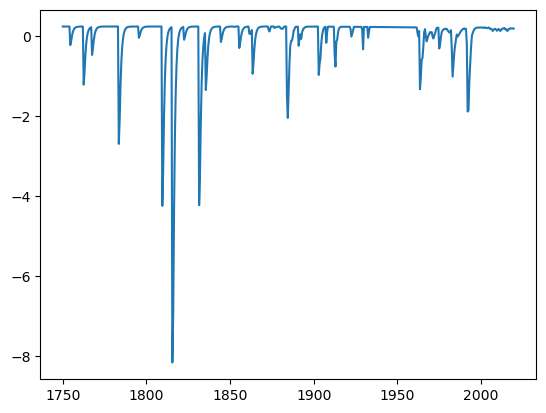

In [29]:
emit = np.zeros((700,1))
emit[200:] = 30

fill(f.emissions.sel(specie='CO2'), emit[:, None])
fill(f.emissions.sel(specie='CO2 AFOLU'), emit[:, None])
fill(f.emissions.sel(specie='Sulfur'), emit[:, None])

In [30]:
f.run()

Running 2 projections in parallel: 100%|█| 700/700 [00:00<00:00, 1132.86timestep


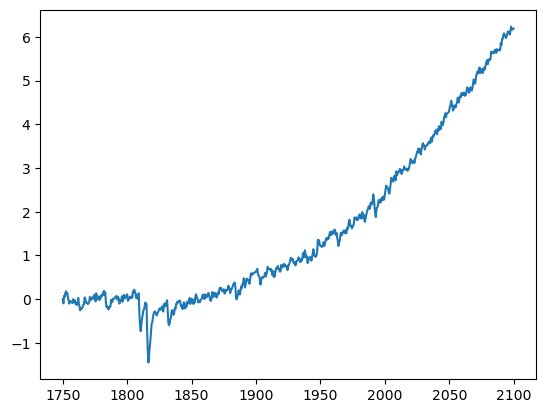

In [31]:
plt.plot(f.timebounds, f.temperature.sel(layer=0, scenario='ssp370')[:, 0])

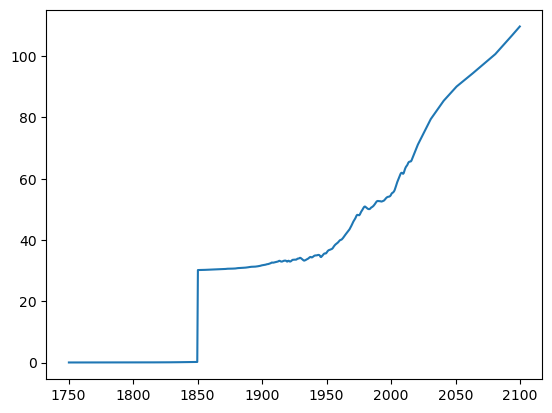

In [32]:
plt.plot(f.timepoints, f.emissions.sel(specie='CO2')[:, 0, 0])

# Other models

In [1]:
class Simulator(gym.Env):
    
    def __init__(self, reward_mode=temp_emit_diff_reward, max_carbon=32, max_aerosol=100, clim_model=model_reset(),
                current_year=2023, end_year=2104, scenario=scenario):
        
        # action space for the environment,
        # the amount to increase or decrease emissions by
        self.action_space = gym.spaces.Box(
            low = np.array([-max_carbon, 0]).astype(np.float32),
            high = np.array([max_carbon, max_aerosol]).astype(np.float32),
        )
        
        self.model = clim_model 
        if(ref_model):
            self.ref_model = ref_model # used for resetting due to saved params
        
        # state space, [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
        self.observation_space = gym.spaces.Box(
            low=np.array([1700, -4, -200, -100, 0, -100.0]).astype(np.float32),
            high=np.array([3000, 20, 200, 1000, 5000, 100]).astype(np.float32),
        )
        
        self.reward_func = eval(reward_mode) if type(reward_mode)==str else reward_mode # specify the reward function to use
        self.scenario = scenario
        self.scenario_emissions = ssp_df
        self.state = None
        
        #for feasibility testing later
        self.ssp_370 = ssp('ssp370')
        
        # setup time bounding
        self.start_year = current_year
        self.end_year = end_year
        self.time_increment = self.model.timesteps_per_year # gonna be 1
        
        self.sulfur_emitted_last_year = 0
    
        
    def reset(self, change=True):
        
        ## MUCH faster than calling setup_model() again
        self.model = model_reset()
        self.t = self.start_year - 1
        if(not change and bool(self.state)):
            return self.state
        
        self.update_state(self.ref_model.emissions)
        
        return([self.state['Year']] + self.state[self.model.configs[1]])                           
    
    
    def update_state(self, emissions):
        
        self.forward_func(emissions)   
        # state is [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]   
        # state refers to at the conclusion of year X, all variables. At end, we are at beginning of year X+1
        self.state = {
            'Year' : self.t,
            self.model.configs[0] : [
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[0], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[0], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[0]].item()                
            ],
            self.model.configs[1] : [ 
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[1], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[1], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[1]].item()
            ]
        }
                               
        self.t += self.time_increment
    
    def forward_func(self, emissions):

        self.model = model_reset()
        self.model.emissions = emissions.copy(deep=True)
        
        self.model.run(progress=False)
    
    def aerosol_cost(emit, previous_emit):
        # 3 factors: operating cost, construction cost, sulfur cost
        num_airplanes = emit / annual_delivery_capacity # how many airplaces deployed
        operational_cost = num_airplanes * cost_per_year_deployed
        
        num_new_airplaces = (emit-previous_emit) / annual_delivery_capacity # number of new planes needed to service additional emissions
        construction_cost = max(num_new_airplaces, 0) * airplane_construction_cost # cost of constructing new plances
        
        sulfur_cost = emit * cost_per_MT
        
        return(sulfur_cost + construction_cost + operational_cost)
        
    
    def render(self, mode="human"):
        if(self.state):
            print(f"Current Year: {self.state['Year']}")
            print("Without intervention:")
            config = self.model.configs[0]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
            
            print("\nWith intervention:")
            config = self.model.configs[1]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
        else:
            print("No state initialized; call reset. ")
    
    
    def step(self, action):
        
        #should not call step without calling reset()
        if(not self.state): #has not been initialized
            self.reset()
        config = self.model.configs[1] #intervention
        old_state = self.state[config] #save for reward function
        
        done = False
        
        
        # change emissions by action[0] from the previous year
        # emit action amount additional sulfur within same year
        new_emissions = self.model.emissions
        emit_C = max(new_emissions.loc[self.t-0.5, self.model.scenarios[0], config, 'CO2 FFI'] + action[0], 0)
        emit_S = new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] + action[1]
        
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'CO2 FFI'] = emit_C
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] = emit_S
        
        
        # run model simulation with new values
        #state is [year, temp, emit_c, emit_s, conc_c, forcing]
        self.update_state(new_emissions) #CAUTION! self.t has now changed
        
        #Implementation of S, Y and Y_cost
        year = self.t - 1 # because updated to next year
        gamma = 1 / ( 1+(S[year-1]/sigma)**rho )
        Y[year] = (1+beta) * Y[year-1]
        
        sulfur_cost = aerosol_cost(action[1], self.sulfur_emitted_last_year)
        
        Y_cost[year] = (10/5 * self.state[config][0] - 2)/100 * Y[year] + sulfur_cost
        S[year] = S[year-1] + ( (1-gamma)*Y[year-1]/epsilon - S[year-1]/tau_S )
        # fail if temperature error
        if math.isnan(self.state[config][0]):
            done = True
        
        
        cur_fease = self.state[config][1] - ssp_df[ssp_df['Year']==self.state['Year']]['CO2-fossil (GtC/yr)'].squeeze() # positive if emitted more than default, otherwise negative
        cur_GDP = Y[year] - Y_cost[year]
        
        #compute the reward
        # TODO: UPDATE ECONOMIC MODEL
        
        reward = self.reward_func(old_state, self.state[config], year, cur_GDP, Y_cost[year], cur_fease)
        

        # end the trial once 2100 is reached
        if self.t == self.end_year or self.state[config][0] > 4: # only runs to 2100
            done = True
        
        self.sulfur_emitted_last_year = action[1]
        
        observation = [self.state['Year']] + self.state[self.model.configs[1]]
        
        return observation, reward, done, {}
        




NameError: name 'gym' is not defined